# Semantic space of cartomancy

By [Allison Parrish](http://www.decontextualize.com/)

(Note: Rough draft! Notes incomplete. FIXME: Needs example at the end for predicting from user-supplied text.)

In this notebook, I'm going to take you through a couple of simple, well-known techniques for exploring small sequences of text—like Tarot interpretations. These techniques include:

* Making vectors for text sequences
* Nearest-neighbor lookups for semantic similarity
* Visualizing corpora with t-SNE
* Clustering sentence vectors to discover similar items

The goal is to better understand the semantic structure of oracle decks.

## Installation and preliminaries

I'm going to use [spaCy](http://spacy.io/) extensively, both as a way to parse text into sentences and also as a source for pre-trained word vectors. Make sure you have it installed, along with the `en_core_web_md` or `en_core_web_lg` models. If you're using Anaconda, you can install spaCy and the English language model with the following commands:

    conda install -c conda-forge spacy
    python -m spacy download en_core_web_md


This notebook also assumes that you have [scikit-learn](https://scikit-learn.org/stable/) and [numpy](https://numpy.org/) installed (these come with standard Anaconda installations).

We'll also be using a library called [simpleneighbors](https://github.com/aparrish/simpleneighbors). To install this, try:

    pip install simpleneighbors[annoy]
    
If that doesn't work (i.e., you get an error about a missing compiler or something), try:

    pip install simpleneighbors[sklearn]
    
Once you're done installing, you should be able to import the modules with the cells below:

In [13]:
import numpy as np
import spacy
from simpleneighbors import SimpleNeighbors

In [2]:
import gzip, json, random

The following cell loads spaCy's language model (this might take a sec):

In [3]:
nlp = spacy.load('en_core_web_md')

## Tarot cards and interpretations

Download [this file](https://github.com/dariusk/corpora/blob/master/data/divination/tarot_interpretations.json) and put it into the same directory as this notebook. (If you cloned the repository, it's already there!) The file contains structured data about the 78 cards in the Tarot deck, and their interpretation. It's in JSON format, so we have to parse it with Python's `json` library to make the data available:

In [4]:
import json
tarot_data = json.load(open("tarot_interpretations.json"))

The structure of the data is a little bit tricky, and there's more in there than we need for our experiments in this notebook. The cell below creates a list of tuples with each tarot card associated with its interpretation. (The interpretations are created by joining together the values for the `fortune_telling` key in the JSON file for each card.)

In [5]:
tarot_cards = []
for item in tarot_data['tarot_interpretations']:
    tarot_cards.append((item['name'], "; ".join(item['fortune_telling'])))

The following cell does a simple Tarot spread, sampling three cards at random and showing them with their interpretations:

In [6]:
random.sample(tarot_cards, 3)

[('nine of coins',
  "Until you appreciate what you have, you won't have any luck getting more"),
 ('The Emperor',
  'A father figure arrives; A new employer or authority figure will give you orders; Expect discipline or correction in the near future'),
 ('four of wands',
  'Someone is watching and evaluating your work; You may get a wedding invitation soon')]

For convenience, the following cell creates a dictionary that makes it easy to look up the interpretation for a given card:

In [7]:
tarot_lookup = dict(tarot_cards)

Look up the meaning of the two of coins:

In [8]:
tarot_lookup['two of coins']

"It's time to balance the budget; Avoid the temptation to spend critical funds on frivolous goods"

(Note that I don't especially agree with many of the interpretations in this JSON file! This is an especially poor interpretation in my opinion. But these interpretations are what we have to work with, so let's move forward.)

Finally, a list of just the card names:

In [9]:
tarot_labels = [item[0] for item in tarot_cards]

## Semantic similarity with word vectors

An immediate goal of this notebook is to make a determination about which Tarot cards have similar interpretations. To do this, we need a measure of semantic similarity: how close are two stretches of text in meaning? For computational purposes, we need to quantify this similarity, and ideally we'd like to be able to visualize it. But how to go about doing this?

Contemporary research in natural language processing offers a solution: the *word vector*. You can [read and follow along with my notebook explaining how word vectors work](https://github.com/aparrish/rwet/blob/master/understanding-word-vectors.ipynb) before continuing, but the short version is that a word vector associates a word with a coordinate in space. Words with similar meanings will have coordinates that are close to each other. (You can think of these coordinates as being on a Cartesian plane (with an X/Y axis), though in reality each coordinate has many more than two dimensions.)

The word vectors that we're using are the [Stanford GloVe vectors](https://nlp.stanford.edu/projects/glove/) included with spaCy. These vectors were produced through an algorithmic process that looked at a large corpus of text and recorded all of the *contexts* that each word occurred in. The vectors are a compressed representation of this list of contexts for each word, so that words that occur in similar contexts have similar vectors. According to the [distributional hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics), words that occur in similar contexts have similar meanings, so vectors representing contexts can serve as a way to represent meanings of words.

Word vectors are not perfect; [they carry with them the biases of the corpora they're trained on](https://towardsdatascience.com/gender-bias-word-embeddings-76d9806a0e17). But they have several interesting properties that afford interesting techniques in computational language arts.

The following cell defines a function `vec()` which makes it easy to get the word vector for a particular word:

In [10]:
def vec(s):
    return nlp.vocab[s].vector

Here's what a vector looks like:

In [11]:
vec('cards')

array([-0.54786  , -0.060409 , -0.34341  , -0.78909  ,  0.76913  ,
        0.062576 , -0.36196  , -0.067923 , -0.24321  ,  1.4941   ,
       -0.0050086,  0.13367  ,  0.044146 , -0.15426  , -0.083489 ,
       -0.085395 , -0.9413   ,  1.6464   , -0.02296  , -0.08399  ,
       -0.19905  ,  0.33439  , -0.12289  , -0.030612 ,  0.29691  ,
       -0.35093  , -0.021799 , -0.036572 , -0.66472  , -0.0036923,
       -0.15867  , -0.22094  , -0.096175 ,  0.021781 , -0.3915   ,
        0.54463  , -0.43797  , -0.21985  , -0.23609  ,  0.13824  ,
       -0.15661  ,  0.14144  ,  0.019459 , -0.66783  , -0.05219  ,
        0.012071 , -0.46731  , -0.13634  , -0.055697 ,  0.39305  ,
       -0.11922  , -0.061792 ,  0.56273  , -0.53199  , -0.14907  ,
       -0.11057  ,  0.31247  ,  0.30131  , -0.43884  ,  0.11746  ,
        0.07021  ,  0.33124  ,  0.39057  , -0.069946 ,  0.15441  ,
        0.46396  ,  0.0040996,  1.0562   ,  0.36647  , -0.28721  ,
        0.082222 ,  0.00213  ,  0.34582  , -0.0446   ,  0.4678

### A distributional thesaurus

The following code builds an index of common words and their vectors. You can use this index to look up words considered to be close in meaning to a given word. (We won't use this for anything in the rest of the notebook, but it's fun to play with.)

In [14]:
thesaurus = SimpleNeighbors(300)
for item in nlp.vocab:
    if item.has_vector and item.prob > -15 and item.is_lower:
        thesaurus.add_one(item.text, item.vector)
thesaurus.build(50)

In [15]:
thesaurus.nearest(vec('magician'), 5)

['genie', 'magic', 'magician', 'magical', 'enchantment']

## Sentence vectors

Word vectors work great when we're interested in individual words. More often, though, we're interested in longer stretches of text, like sentences, lines, paragraphs. If we had a way to represent these longer stretches of text as vectors, we could perform all of the same operations on them that word vectors allow us to perform on words. But how to represent stretches of text as sequences?

There are lots of different ways! The classic technique in machine learning is to use the frequency of terms found in each sequence (methods like [tfidf](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)), or similar techniques like [doc2vec](https://rare-technologies.com/doc2vec-tutorial/). Another way is to train a recurrent neural network (like an LSTM) and use its hidden state. Another is to use a pre-trained model, like Google's [Universal Sentence Encoder](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html).

But a surprisingly effective technique is to simply average together the word vectors for each word in the sentence. A big advantage of this technique is that *no further training is needed*, beyond the training needed to calculate the word vectors; if you're using pre-trained vectors, even that step can be skipped. You won't get state-of-the-art results on NLP benchmarks with this technique, but it's a good baseline and still useful for many tasks.

The function below produces a vector that represents the meaning of a sentence with an average of the vectors for each word in the sentence. The function *weights* each word's contribution to the average based on the inverse of its frequency in English (according to spaCy's built-in word frequency information). The intention of weighting by inverse frequency is to reduce the contribution of common function words like "the" and "of" to the sentence vector. (This approach was inspired by [Arora et al.'s Smooth Inverse Frequency technique](https://github.com/PrincetonML/SIF), though my approach doesn't remove the principle component.)

In [16]:
def sentence_summary(sent, a=0.001):
    s = nlp(sent, disable=['parser', 'tagger', 'ner'])
    weights = [a / (a + np.exp(tok.prob)) for tok in s]
    emb = np.average([tok.vector for tok in s], axis=0, weights=weights)
    return emb

The code in the cell below computes and returns the embeddings every string in a list:

In [17]:
def embeddings(text_list):
    return [sentence_summary(item) for item in text_list]

And here we calculate embeddings for every Tarot interpretation:

In [18]:
tarot_embeddings = embeddings([interpretation for card, interpretation in tarot_cards])

And here's what they look like:

In [19]:
rand_idx = random.randrange(len(tarot_embeddings))
tarot_cards[rand_idx], tarot_embeddings[rand_idx]

(('ace of coins',
  "Your health will improve; The check you're looking for really is in the mail"),
 array([-7.48437062e-02,  2.38817390e-01, -2.60202422e-01,  6.45209687e-03,
        -5.76540027e-02,  9.11737805e-04, -7.95287452e-02, -3.14694786e-01,
        -8.11702077e-02,  2.32743427e+00, -5.00491939e-01,  3.74548861e-02,
         1.31327028e-02, -6.07544370e-02, -7.64834004e-02,  9.26227071e-04,
        -9.57607638e-02,  1.55665597e+00, -3.24453771e-01,  7.33627906e-02,
         1.14888679e-02,  1.70832060e-01, -2.99182090e-02, -1.18720762e-01,
         5.66484608e-02,  1.36779241e-02, -7.04350782e-02, -1.41377904e-01,
         1.98921806e-01, -2.15919173e-01, -7.38209155e-02, -1.32633572e-02,
         4.55063377e-02, -1.58357770e-02,  3.85797984e-02, -1.66530833e-03,
        -3.66343062e-02,  1.22332848e-01,  9.88227520e-03, -5.77911806e-02,
        -6.06664125e-02,  3.09903999e-02, -1.21920058e-01, -2.43932289e-01,
        -4.46682993e-02,  9.22677711e-02, -9.96118580e-02,  1.5

## A Tarot search engine

Sentence vectors aren't especially interesting on their own! One thing we can use them for is to build a tiny "search engine" based on semantic similarity between cards. To do this, we need to be able to calculate the distance between a target sentence's vector (not necessarily a sentence from our corpus) and vectors of the sentences in the corpus, returning them ranked based on the distance between the two vectors. We'll use another `SimpleNeighbors` object to perform fast lookups based on similarity.

First, I build an approximate nearest neighbors index using the vectors I got from the inverse frequency weighting technique:

In [20]:
tarot_nn = SimpleNeighbors(300)
for vec, (card, interpretation) in zip(tarot_embeddings, tarot_cards):
    tarot_nn.add_one(card, vec)
tarot_nn.build(50)

The `.nearest()` method returns the sentences from the corpus whose vectors are closest to the vector you pass in. The code in the cell below uses the `sentence_summary()` function to return the interpretations most similar to the sentence you type in. The number controls how many sentences should be returned.

In [25]:
tarot_nn.nearest(sentence_summary("happiness and contentment"), 5)

['ten of cups', 'six of cups', 'The Lovers', 'The Hermit', 'queen of cups']

The same idea, but also prints out the interpretation for the card:

In [26]:
for item in tarot_nn.nearest(sentence_summary("happiness and contentment"), 5):
    print(item)
    print(tarot_lookup[item])
    print()

ten of cups
Marriage and family are in the cards; Expect a friendship to blossom into a romance

six of cups
A stingy spirit is strangling your enjoyment of life; Loosen up and think of others for once, why don't you?

The Lovers
A new personal or professional relationship blossoms; Sexual opportunities abound; Unexpectedly, a friend becomes a lover

The Hermit
A period of loneliness begins; One partner in a relationship departs; A search for love or money proves fruitless

queen of cups
This card represents a woman with an emotional, deeply spiritual nature, likely born between June 11th and July 11th, who uses emotional and spiritual appeals to sway others to her point of view



To get neighbors for a particular card:

In [27]:
tarot_nn.neighbors('The Sun', 5)

['The Sun', 'The Moon', 'five of wands', 'ten of wands', 'nine of wands']

To get neighbors for a random item in the corpus:

In [28]:
tarot_nn.neighbors(random.choice(tarot_nn.corpus), 5)

['Death', 'The Hermit', 'The Hanged Man', 'The Empress', 'six of swords']

### Finding cards "in between"

A benefit of representing meaning as points in space is that we can perform vector arithmetic on those vectors. One operation of interest is finding the midpoint between two points (i.e., averaging two points). If we find the vectors for two cards, then average those vectors together and find the card nearest to that point, we'll get a card that is "between" the two other cards in terms of their meaning.

The following function averages two vectors:

In [29]:
def average(v1, v2):
    return (np.array(v1) + np.array(v2)) / 2

And then this code prints out the five cards nearest to the midpoint of the two named cards. (Often the first two nearest cards are the source and destination themselves. Weirdly, `The Moon` tends to be the midpoint in most of my experiments for any two cards!)

In [30]:
src = 'ace of coins'
dest = 'Death'
for item in tarot_nn.nearest(average(tarot_nn.vec(src), tarot_nn.vec(dest)), 5):
    print(item)
    print(tarot_lookup[item])
    print()

ace of coins
Your health will improve; The check you're looking for really is in the mail

Death
A relationship or illness ends suddenly; Limit travel and risk-taking; General gloom and doom

The Moon
Watch for problems at the end of the month; Someone you know needs to howl at the moon more often; Someone is about to change his or her mind about an important decision

Judgement
An old issue you thought was over will come up again today; Get ready for huge changes: break-ups, sudden calls from old friends, and unexpected setbacks; God's trying to get your attention

The Magician
A powerful man may play a role in your day; Your current situation must be seen as one element of a much larger plan



## Visualize tarot space in two dimensions

Another thing you can do with sentence vectors is *visualize* them. But the vectors are large (in our case, 300 dimensions), which doesn't have an obvious mapping to 2-dimensional space. Thankfully, there are a number of algorithms to *reduce* the dimensionality of vectors. We're going to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ("t-distributed stochastic neighbor embedding"), but there are others to experiment with that might be just as good or better for your application (like [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA) or [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [31]:
from sklearn.manifold import TSNE
mapped_embeddings = TSNE(n_components=2,
                         metric='cosine',
                         init='pca',
                         learning_rate=75,
                         perplexity=15,
                         n_iter=5000,
                         verbose=1).fit_transform(tarot_embeddings)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 78 samples in 0.000s...
[t-SNE] Computed neighbors for 78 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 78 / 78
[t-SNE] Mean sigma: 0.125879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.816658
[t-SNE] KL divergence after 3000 iterations: 0.518916


The following function draws an image with the results of the t-SNE. (You can control-click or right-click to save it.)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
def disp_tsne(embeddings, labels, figsize=12):
    plt.figure(figsize=(figsize, figsize))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y)
    for i, item in enumerate(labels):
        plt.annotate(labels[i], (x[i], y[i]))

And the following calls the function with the result of the TSNE:

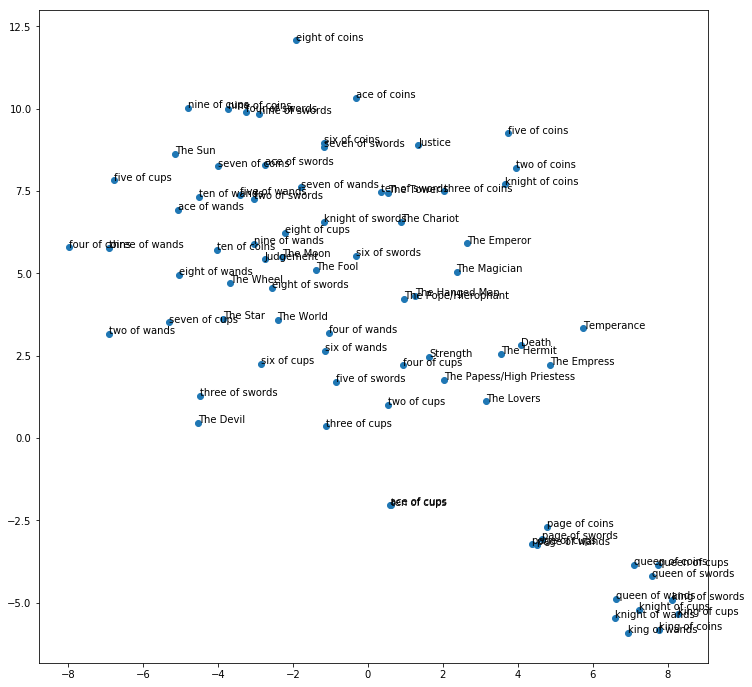

In [33]:
disp_tsne(mapped_embeddings, tarot_labels)

### Exporting for Google embedding projector

Upload these files [here](https://projector.tensorflow.org/).

In [34]:
with open("tarot-emb-proj-vecs.tsv", "w") as fh:
    for item in tarot_embeddings:
        fh.write("\t".join(["%0.5f" % val for val in item]))
        fh.write("\n")

In [35]:
with open("tarot-emb-proj-labels.tsv", "w") as fh:
    fh.write("\n".join(tarot_labels))

## Finding clusters

In the visualization above, you may have seen some evidence of "clustering"—groups of items that seem to be related. There are algorithms that facilitate finding such clusters *automatically*. This can be an interesting and valuable way to explore your data—you might find clusters of meaning that you didn't expect.

We're going to use the [K-Means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) (in particular, scikit-learn's [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)).

K-Means is an unsupervised algorithm, meaning that you don't need to label the data for it to work. But you do need to specify how many clusters you expect to find:

In [36]:
cluster_count = 5 # adjust this until it starts giving you good results!

The code in the following cell computes clusters for the given sets of embeddings, labels and cluster count:

In [37]:
from sklearn.cluster import MiniBatchKMeans
from collections import defaultdict

def cluster_labels(embeddings, labels, cluster_n):
    clusterer = MiniBatchKMeans(n_clusters=cluster_n)
    clusters = clusterer.fit_predict(embeddings)
    group_by_cluster = defaultdict(list)
    for i, item in enumerate(clusters):
        group_by_cluster[item].append(labels[i])
    centers = [clusterer.cluster_centers_[i] for i in range(cluster_n)]
    groups = [group_by_cluster[i] for i in range(cluster_n)]
    return (centers, groups)

Let's calculate this for our Tarot embeddings and cards. The function also returns the center of each cluster:

In [38]:
centers, groups = cluster_labels(tarot_embeddings, tarot_labels, cluster_count)

The code in the following cell takes this information and prints it out. Each cluster is shown along with at most five cards that belong to it and the card closest to the center of the cluster.

In [39]:
for i in range(cluster_count):
    print(f"Cluster {i} ({len(groups[i])} items)")
    print("Closest to center: ", list(tarot_nn.nearest_matching(centers[i], 1, lambda x: x in groups[i]))[0])
    print("All cards: ", ", ".join(groups[i]))
    print()
    for card_label in random.sample(groups[i], min(5, len(groups[i]))):
        print(card_label)
        print(tarot_lookup[card_label])
        print()
    print("\n---")

Cluster 0 (4 items)
Closest to center:  ace of cups
All cards:  The Lovers, ace of cups, three of cups, ten of cups

ace of cups
Romance is in the cards; A new relationship or marriage is just around the corner; Prayers are answered

three of cups
Unconventional romance is coming your way: a love affair with someone you've always dismissed

ten of cups
Marriage and family are in the cards; Expect a friendship to blossom into a romance

The Lovers
A new personal or professional relationship blossoms; Sexual opportunities abound; Unexpectedly, a friend becomes a lover


---
Cluster 1 (30 items)
Closest to center:  The Moon
All cards:  The Fool, The Wheel, Justice, The Tower, The Moon, The Sun, Judgement, three of wands, four of wands, five of wands, seven of wands, nine of wands, ten of wands, eight of cups, nine of cups, ace of swords, two of swords, four of swords, six of swords, seven of swords, eight of swords, nine of swords, ten of swords, knight of swords, ace of coins, four of co

K-Means clustering has a random component, so you won't necessarily end up with the same clusters every time. With higher numbers of clusters, you tend to get clusters that only have one or two items (not ideal). A repeating pattern for me is that the court cards tend to end up in the same cluster and The Moon tends to be the center of large clusters. Not sure why!

## Oracle decks

We can consider Tarot to be one exemplar of the category of "oracle decks."

In this repository, there's a file called `oracle-corpus.tsv`. This consists of a tab-separated file with several thousand potential oracle cards, drawn from the Tarot interpretations file and a book of dream interpretations.

This section of the notebook performs the same analysis we performed on the Tarot deck, but with this TSV instead. It'll work with any TSV though!

Because this TSV has some duplicate cards, I added some code that adds random numbers to the end of the card's name (in order to disambiguate between duplicates). The numbers don't actually mean anything.

In [40]:
already_seen = set()
deck = []
for line in open("./oracle-corpus.tsv"):
    line = line.strip()
    card, interp = line.split("\t")
    # dealing with duplicates
    if card in already_seen:
        card += "/%04d" % random.randrange(10000)
    already_seen.add(card)
    deck.append((card, interp))

In [41]:
random.sample(deck, 10)

[('petticoat', 'your reluctance in revealing something about yourself'),
 ('blog', 'your popularity'),
 ('photo_booth',
  'things that are thought to be private may not be so private'),
 ('tractor', 'your resourcefulness and ingenuity'),
 ('mink', 'value, warmth, riches, or luxury'),
 ('sushi', 'you need to acknowledge your spiritual side'),
 ('monster/8338', 'aspects of yourself that you find repulsive and ugly'),
 ('post-it_note', 'there is something that you need to make a mental note of'),
 ('devil/6041', 'you will succeed in defeating your enemies'),
 ('erosion', 'a situation or relationship that is wearing away')]

A dictionary to look up interpretations for cards:

In [42]:
deck_lookup = dict(deck)

Look up the meaning of the two of coins:

In [43]:
deck_lookup['flesh']

'a heightened sense of feeling and vitality'

Finally, a list of just the card names:

In [44]:
deck_labels = [item[0] for item in deck]

### Oracle nearest neighbors

Building a nearest neighbors index:

In [45]:
deck_embeddings = embeddings([interpretation for card, interpretation in deck])

In [46]:
deck_nn = SimpleNeighbors(300)
for vec, (card, interpretation) in zip(deck_embeddings, deck):
    deck_nn.add_one(card, vec)
deck_nn.build(50)

The `.nearest()` method returns the sentences from the corpus whose vectors are closest to the vector you pass in. The code in the cell below uses the `sentence_summary()` function to return the interpretations most similar to the sentence you type in. The number controls how many sentences should be returned.

In [47]:
deck_nn.nearest(sentence_summary("everything will be fine!"), 5)

['tart', 'face/5958', 'funeral', 'comfort', 'luck']

The same idea, but also prints out the interpretation for the card:

In [48]:
for item in deck_nn.nearest(sentence_summary("everything will be fine!"), 5):
    print(item)
    print(deck_lookup[item])
    print()

tart
things are going well for you

face/5958
you need to come clean about some matter

funeral
something in your life needs to put to rest or put aside so that you can make room for something new

comfort
Appreciating fine food, fine wine, beautiful art, beautiful bodies, or any of the better things in life

luck
things will look up for you



To get neighbors for a particular card:

In [49]:
deck_nn.neighbors('luck', 5)

['luck', 'lens', 'tart', 'joint', 'staring']

To get neighbors for a random item in the corpus:

In [50]:
deck_nn.neighbors(random.choice(deck_nn.corpus), 5)

['pole_vaulting', 'trough', 'pineapple', 'roommate', 'boxing_glove']

### Oracle deck interpretations

Because we used the same embedding procedure for both our oracle deck cards and the Tarot deck, we can find oracle cards that are close in meaning to Tarot cards:

In [51]:
for item in deck_nn.nearest(tarot_nn.vec('The Fool'), 5):
    print(item)
    print(deck_lookup[item])
    print()

sit_up
you need to pay better attention to something in your life, like a relationship, school, work, family, or project

gear/8969
you are ready to move forward with a new project in your life

astral_projection
you are looking at things from a whole new perspective

new_year
prosperity, hope, new beginnings and an opportunity to make a fresh start

originality/9359
Putting old things together in new and exciting ways



Looking up Oracle cards halfway between the Tarot cards `ace of coins` and `Death`:

In [52]:
src = 'ace of coins'
dest = 'Death'
for item in deck_nn.nearest(average(tarot_nn.vec(src), tarot_nn.vec(dest)), 5):
    print(item)
    print(deck_lookup[item])
    print()

path
you need to give serious attention to the direction you are heading in your personal and/or business life

comic
you refuse to see the problems that exist in your life and only want to focus on the good times

bet
you are taking a risk in a relationship or work situation which may not be such a wise choice

outbound
Taking what you want without concern for the needs of others

camper
you need to move on with some situation or some aspect of your life



This code picks two cards at random and then prints the card that is between the two in meaning.

In [67]:
src = deck_nn.vec(random.choice(deck_nn.corpus))
dest = deck_nn.vec(random.choice(deck_nn.corpus))
avg = average(src, dest)
src_card = deck_nn.nearest(src, 1)[0]
avg_card = deck_nn.nearest(avg, 1)[0]
dest_card = deck_nn.nearest(dest, 1)[0]
print(src_card)
print(deck_lookup[src_card])
print()
print(avg_card)
print(deck_lookup[avg_card])
print()
print(dest_card)
print(deck_lookup[dest_card])

herd
you are a follower

sunglasses
you are having a hard time getting to know this person

pacifier/1560
you are trying to "suck up to" someone in your waking life


### Visualizing oracle space

This is the same T-SNE code as above, but applied to the oracle card embeddings.

Note in the code below, I'm using an even smaller subset of the data. (That's what the `[:2000]` is doing—just using the first 2000 samples.) This is because t-SNE is *slow*, as is drawing the results of a t-SNE).

In [68]:
from sklearn.manifold import TSNE
deck_mapped_embeddings = TSNE(n_components=2,
                         metric='cosine',
                         init='pca',
                         learning_rate=75,
                         perplexity=15,
                         n_iter=1000,
                         verbose=1).fit_transform(deck_embeddings[:2000])

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.012s...
[t-SNE] Computed neighbors for 2000 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.137747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.509010
[t-SNE] KL divergence after 1000 iterations: 1.874479


Because there are more labels, we need to make the image larger so we can see them all clearly. You may need to save this and open in an image viewing tool (like macOS Preview) to see everything comfortably.

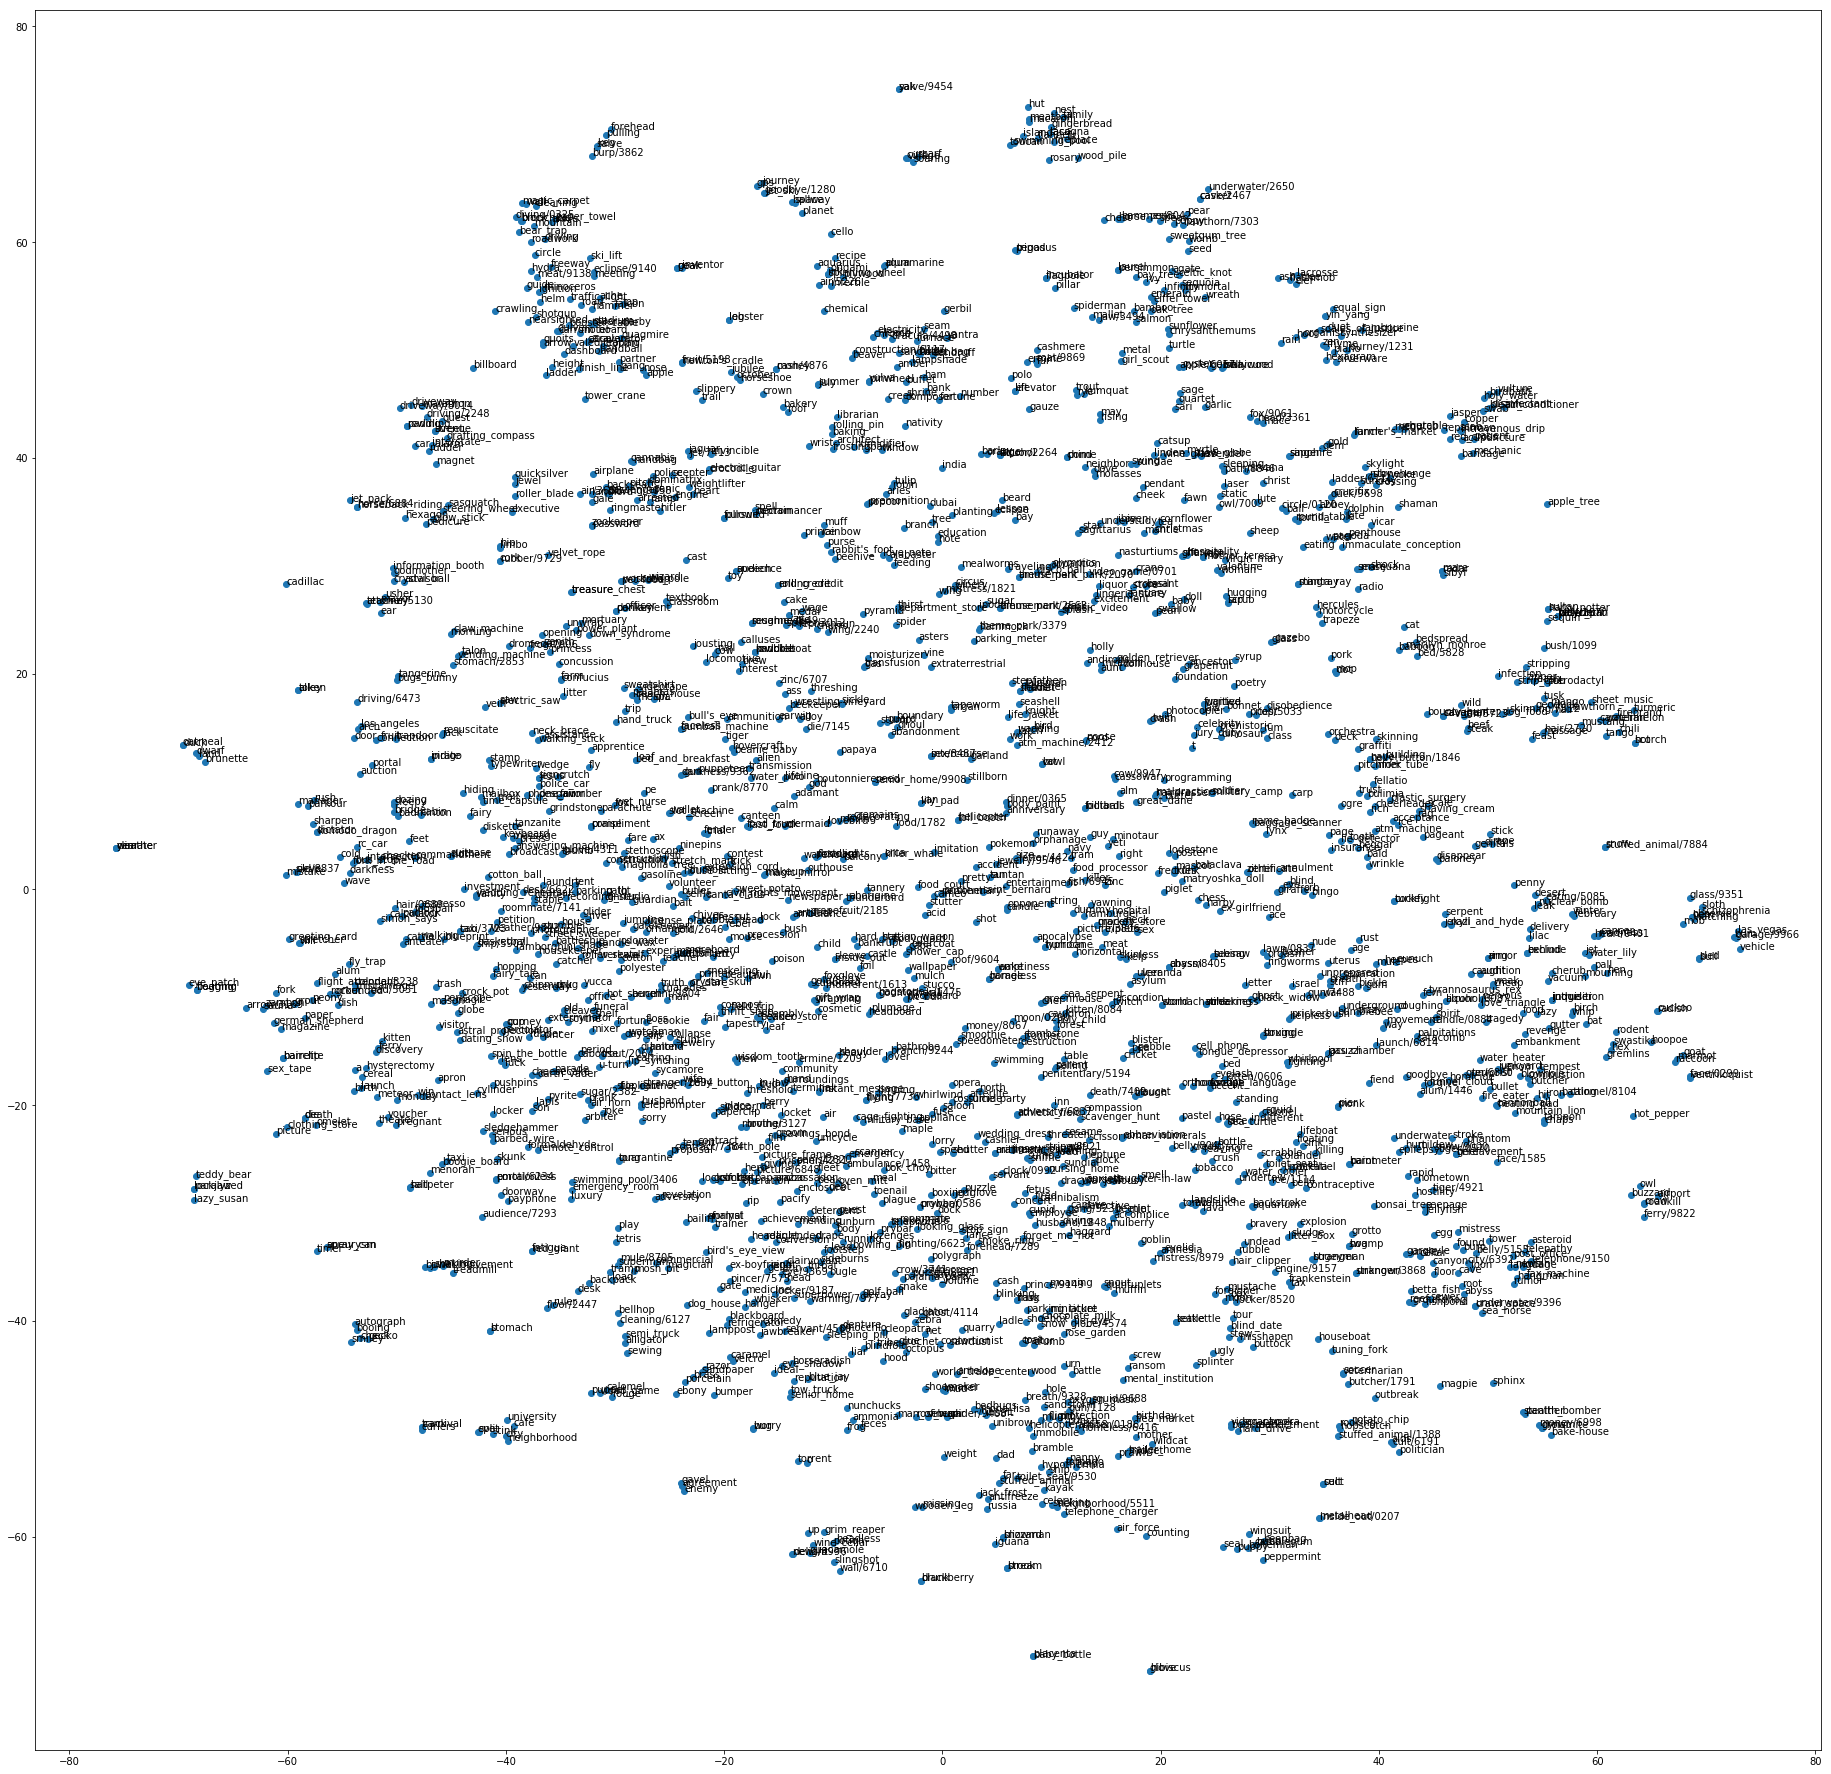

In [69]:
disp_tsne(deck_mapped_embeddings, deck_labels[:2000], 32)

Exporting for Google embedding projector: upload these files [here](https://projector.tensorflow.org/).

In [70]:
with open("deck-emb-proj-vecs.tsv", "w") as fh:
    for item in deck_embeddings:
        fh.write("\t".join(["%0.5f" % val for val in item]))
        fh.write("\n")

In [71]:
with open("deck-emb-proj-labels.tsv", "w") as fh:
    fh.write("\n".join(deck_labels))

### Oracle clusters

I think this might actually be a valid and interesting way to generate ideas for an oracle deck! We cluster all 8000+ cards into groups. One way of thinking about this is that we've found a way to "factor out" similar cards, getting at the underlying core ideas of the deck. Set the cluster count to the number of cards you want, and voila—computer-generated oracle deck that maximally covers all possible divinatory semantics.

In [77]:
cluster_count = 13 # adjust this until it starts giving you good results!

In [78]:
centers, groups = cluster_labels(deck_embeddings, deck_labels, cluster_count)

The code in the following cell takes this information and prints it out. Each cluster is shown along with at most five cards that belong to it:

In [79]:
for i in range(cluster_count):
    print(f"Cluster {i} ({len(groups[i])} items)")
    print("Closest to center: ", list(deck_nn.nearest_matching(centers[i], 1, lambda x: x in groups[i]))[0])
#    print("All cards: ", ", ".join(groups[i])) # uncomment this if you want to see all of the cards
    print()
    for card_label in random.sample(groups[i], min(5, len(groups[i]))):
        print(card_label)
        print(deck_lookup[card_label])
        print()
    print("\n---")

Cluster 0 (1245 items)
Closest to center:  street_sweeper

quay/6462
you are moving forward into a new phase of your life

productivity
Celebrating your body

adulation/8823
you are willing to part with something near and dear to you in the hopes of material advancement

false_tooth/6042
someone in your life is not who they say they are

sensuality/4547
Reveling in the good things life has to offer


---
Cluster 1 (961 items)
Closest to center:  food/1995

food_poisoning
there is something harming or interfering with your emotional well being

doctor/3096
there is some problem that you need to patch up or some emotional wound you need that to bandage up

adieu
an end to your worries

job/2464
Being ineffectual or lazy

swiss
a metaphor for holes or flaws in your way of thinking


---
Cluster 2 (500 items)
Closest to center:  pretzel

sprinkler
enlightenment, rejuvenation and cleansing

tea/4911
satisfaction and contentment in your life

tortilla
wholeness

river/0989
purification and c

## Generating new cards

With the larger oracle card file, we can use a language model to generate *new* cards. A Markov chain is probably the easiest way to go; you can read my [whole big tutorial on Markov chains and neural networks for text generation](https://github.com/aparrish/predictive-text-and-text-generation/blob/master/predictive-text-and-text-generation.ipynb) for the details. But the quick version is: there's a good Markov chain library for Python that will do the work for you. At the command line, type:

    pip install markovify
    
Markovify does word-level Markov chains by default, but I prefer character-level. This is a little class that implements character-level Markov and also allows you to train on a list of strings (instead of a single big text file).

In [80]:
import markovify
import re
class MarkovLinesByChar(markovify.Text):
    def word_split(self, sentence):
        return list(sentence)
    def word_join(self, words):
        return "".join(words)
    def sentence_split(self, text):
        return re.split(r"\n", text)

We'll create separate models for the card names and the card interpretations:

In [81]:
name_model = MarkovLinesByChar("\n".join([item[0] for item in deck]).lower(), state_size=6)
interpretations_model = MarkovLinesByChar("\n".join([item[1] for item in deck]).lower(), state_size=7)

And then try them out:

In [82]:
name_model.make_sentence(tries=1000)

'surprising/2581'

In [83]:
interpretations_model.make_sentence(tries=1000)

'balance, self-denial'

The following cell prints out ten randomly generated cards:

In [84]:
for i in range(10):
    print(name_model.make_sentence(tries=1000))
    print(interpretations_model.make_sentence(tries=1000))
    print()

fainting/8320
breaking on the goal

shaving_credit_card
you will achieving protection

armored_carpet/4262
you are expand your life

president/2302
you are not earned

destitutional_anthemums
your need for greatness

hot_spring/6141
ruggedness, persona you share and joy

combination/7431
you have over others

sand_castle/6592
refusing the issue or in your life

skydiving_boy
you have to protection

reconcilementations
a looming ruthlessness



Note that the card names and the card interpretations here are totally independent of each other! Markov chains are good at generating language that follows statistical characteristics of a source text, but aren't good at generating text *about* a particular topic. For that, you'll need to use either (a) a model that can take into account long-distance semantic dependencies, like [GPT-2](https://talktotransformer.com/), or (b) a model that can generate text shorter snippets of text conditionally, like a captioning model or a [variational autoencoder](https://github.com/aparrish/vae-lagging-encoder/). But that's a subject for a different tutorial!